1. Live Detection Recognition

Load image, model and preprocess images

In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model
import pickle

conference_model = load_model('Conference_2.keras')

images_path = '5-People/' 

def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            images.append(img)
            labels.append(filename.split('_')[0])  
    return images, labels

def preprocess_images(images, size=(224, 224)):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)
        gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
        normalized_img = cv2.normalize(sobel_magnitude, None, 0, 1, cv2.NORM_MINMAX)
        normalized_img_3channel = np.stack([normalized_img] * 3, axis=-1)
        processed_images.append(normalized_img_3channel)
    return np.array(processed_images)

Global and Local Feature Extraction (ORB)

In [2]:
def extract_conference_features(images, model):
    features = []
    preprocessed_images = preprocess_images(images)  
    for img in preprocessed_images:
        preprocessed_img = np.expand_dims(img, axis=0) 
        feature = model.predict(preprocessed_img)
        features.append(feature.flatten())
    return np.array(features)

def extract_orb_features(images):
    preprocessed_images = preprocess_images(images) 
    
    orb = cv2.ORB_create()
    descriptors = []
    for img in preprocessed_images:
        img_uint8 = (img * 255).astype(np.uint8) 
        gray_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        _, des = orb.detectAndCompute(gray_img, None)
        descriptors.append(des)
    return descriptors

Saving and Loading Extracted Features

In [3]:
def save_features(global_features, global_labels, local_features, save_dir="features_cache_5"):
    os.makedirs(save_dir, exist_ok=True)
    np.savez(os.path.join(save_dir, "global_features.npz"), features=global_features, labels=global_labels)
    with open(os.path.join(save_dir, "local_features.pkl"), "wb") as f:
        pickle.dump(local_features, f)

def load_features(save_dir="features_cache_5"):
    global_data = np.load(os.path.join(save_dir, "global_features.npz"))
    global_features, global_labels = global_data["features"], global_data["labels"]
    with open(os.path.join(save_dir, "local_features.pkl"), "rb") as f:
        local_features = pickle.load(f)
    return global_features, global_labels, local_features

Global and Local Matching functions

In [4]:
def global_matching(query_feature, database_features, database_labels, top_k=5):
    similarities = cosine_similarity([query_feature], database_features)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(database_labels[i], similarities[i]) for i in top_indices]

def local_matching(query_descriptors, candidate_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_per_candidate = []
    for des in candidate_descriptors:
        if des is None or query_descriptors is None:
            matches_per_candidate.append(0)
            continue
        matches = bf.match(query_descriptors, des)
        matches_per_candidate.append(len(matches))
    best_match_idx = np.argmax(matches_per_candidate)
    return best_match_idx, matches_per_candidate

Function for live detection

In [5]:
def live_detection(model, global_features, local_features, labels):
    cap = cv2.VideoCapture(0)
    orb = cv2.ORB_create()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = preprocess_images([frame])[0]  

        processed_frame_uint8 = (processed_frame * 255).astype(np.uint8)

        query_global_feature = model.predict(np.expand_dims(processed_frame, axis=0)).flatten()

        frame_gray = cv2.cvtColor(processed_frame_uint8, cv2.COLOR_RGB2GRAY)
        _, query_local_descriptors = orb.detectAndCompute(frame_gray, None)

        top_candidates = global_matching(query_global_feature, global_features, labels, top_k=5)

        candidate_images_indices = [np.where(labels == label)[0][0] for label, _ in top_candidates]
        candidate_descriptors = [local_features[idx] for idx in candidate_images_indices]

        best_idx, matches_per_candidate = local_matching(query_local_descriptors, candidate_descriptors)

        best_match_label = labels[candidate_images_indices[best_idx]]
        cv2.putText(frame, f"Detected: {best_match_label}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Live Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


Main for live detection

In [6]:
if __name__ == "__main__":
    # images, labels = load_images_from_folder(images_path)

    # global_features = extract_conference_features(images, conference_model)

    # local_features = extract_orb_features(images)

    # save_features(global_features, labels, local_features)
    
    global_features, labels, local_features = load_features()

    live_detection(conference_model, global_features, local_features, labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

2. Image Recognition 

Libraries

In [ ]:
import os
import glob
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

Load InceptionV3 model

In [ ]:
conference_model = load_model('Conference.keras')

Load features function

In [ ]:
def load_features(save_dir="features_cache_5"):
    global_data = np.load(f"{save_dir}/global_features.npz")
    global_features, global_labels = global_data["features"], global_data["labels"]
    with open(f"{save_dir}/local_features.pkl", "rb") as f:
        local_features = pickle.load(f)
    return global_features, global_labels, local_features

Matching Function

In [ ]:
def global_matching(query_feature, database_features, database_labels, top_k=5):
    similarities = cosine_similarity([query_feature], database_features)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(database_labels[i], similarities[i]) for i in top_indices]

def local_matching(query_descriptors, candidate_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_per_candidate = []
    for des in candidate_descriptors:
        if des is None or query_descriptors is None:
            matches_per_candidate.append(0)
            continue
        matches = bf.match(query_descriptors, des)
        matches_per_candidate.append(len(matches))
    best_match_idx = np.argmax(matches_per_candidate)
    return best_match_idx, matches_per_candidate

Handling query image matching

In [ ]:
def extract_orb_features(image):
    orb = cv2.ORB_create()
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descriptors = orb.detectAndCompute(gray_img, None)
    return descriptors

def preprocess_query_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    resized_img = cv2.resize(img_rgb, (224, 224))
    
    blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)
    
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    normalized_img = cv2.normalize(sobel_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    normalized_img_3channel = np.stack([normalized_img] * 3, axis=-1)
    
    normalized_img_3channel = (normalized_img_3channel * 255).astype(np.uint8)
    model_input = np.expand_dims(normalized_img_3channel, axis=0) / 255.0  
    
    return img_rgb, model_input

def group_images_by_label(labels):
    grouped = defaultdict(list)
    for idx, label in enumerate(labels):
        grouped[label].append(idx)
    return grouped

def find_best_match_across_all(query_feature, query_descriptors, grouped_indices, global_features, global_labels, local_features, top_k=5):
    best_overall_match = None
    highest_similarity = -1
    
    for label, indices in grouped_indices.items():
        person_features = global_features[indices]
        person_labels = [global_labels[idx] for idx in indices]
        person_local_features = [local_features[idx] for idx in indices]
        
        top_matches = global_matching(query_feature, person_features, person_labels, top_k=top_k)
        
        candidate_descriptors = person_local_features
        best_local_idx, _ = local_matching(query_descriptors, candidate_descriptors)
        
        best_match_label = person_labels[best_local_idx]
        
        for best_match in top_matches:
            if best_match[0] == best_match_label:
                if best_match[1] > highest_similarity:
                    highest_similarity = best_match[1]
                    best_overall_match = best_match
    
    return best_overall_match

Display Result Function

In [ ]:
def display_query_and_best_match(query_image, best_match, image_dir="5-People/"):
    matched_label, similarity = best_match

    matched_files = glob.glob(f"{image_dir}/{matched_label}_*.jpg")
    if not matched_files:
        print(f"Error: No image found for label '{matched_label}'")
        return

    matched_image_path = matched_files[0]  
    matched_image = cv2.imread(matched_image_path)
    matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(matched_image_rgb)
    plt.title(f"Best Match: {matched_label}\nSim: {similarity:.2f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Image Recognition Main

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


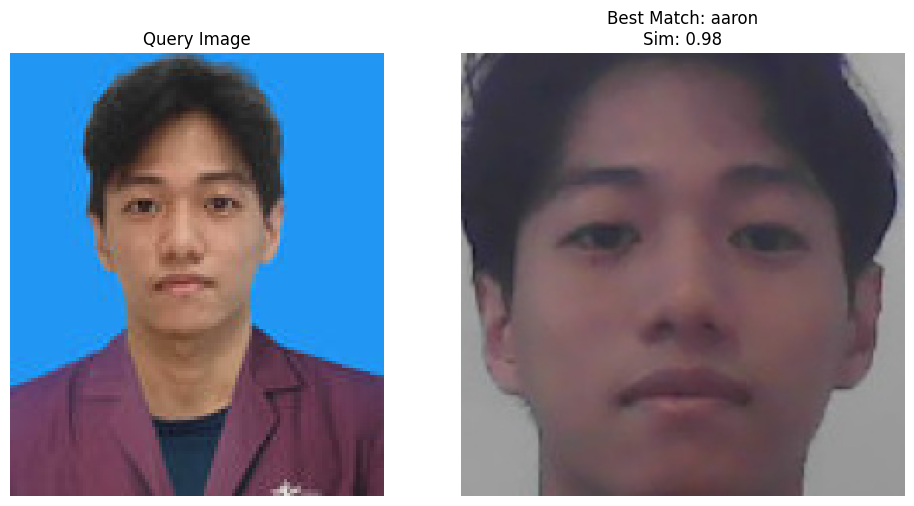

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


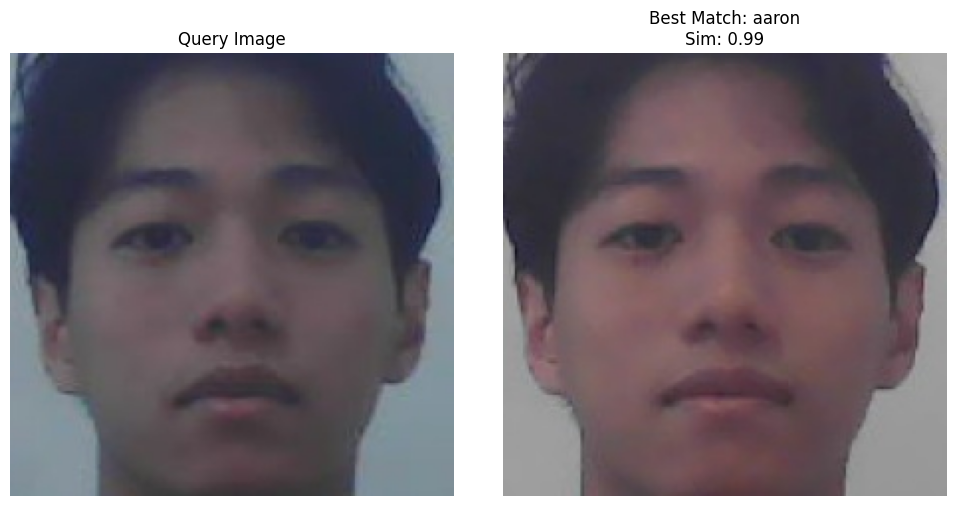

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


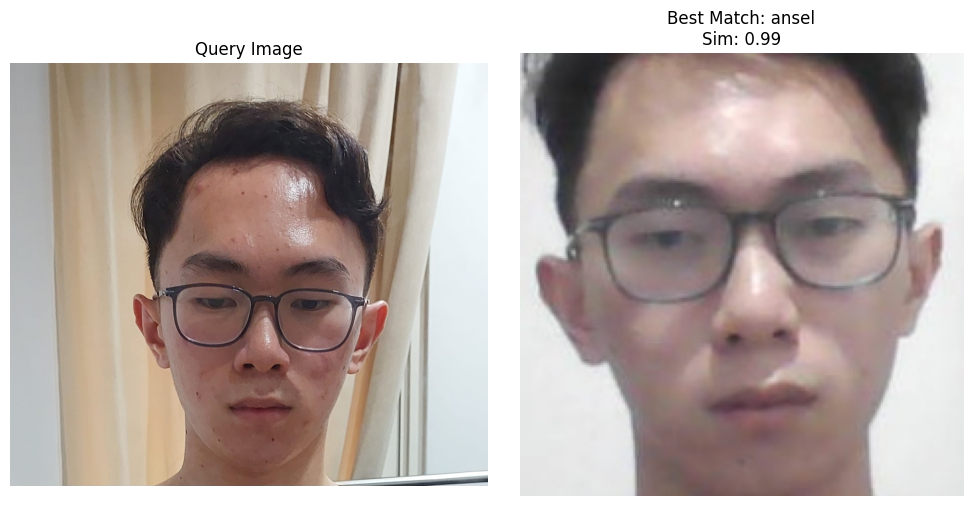

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


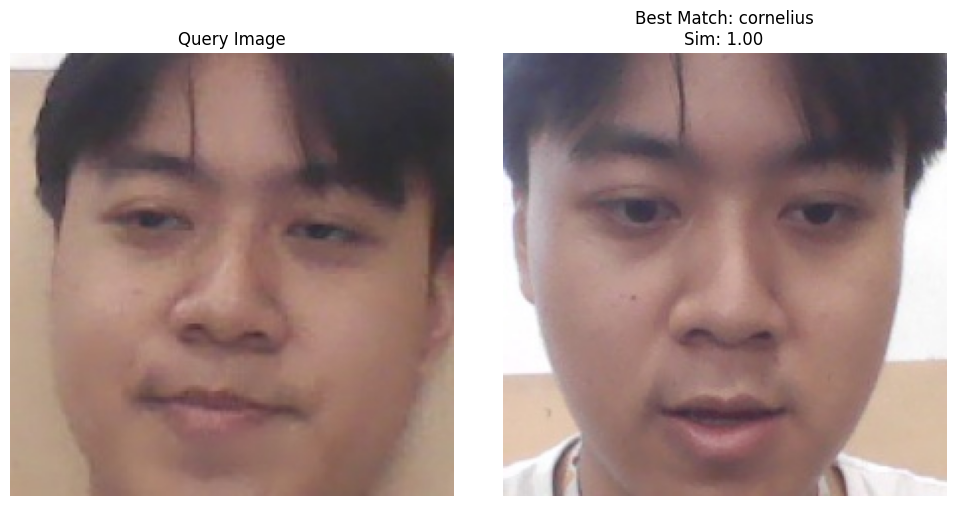

In [ ]:
if __name__ == "__main__":
    global_features, labels, local_features = load_features()

    query_image_path = "BINUS-MAYA/" 

    for img in os.listdir(query_image_path):
        true_path = os.path.join(query_image_path, img)

        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping non-image file: {true_path}")
            continue

        try:
            query_image, preprocessed_query_image = preprocess_query_image(true_path)

            query_global_feature = conference_model.predict(preprocessed_query_image).flatten()

            query_local_descriptors = extract_orb_features(query_image)

            grouped_indices = group_images_by_label(labels)

            best_match = find_best_match_across_all(query_global_feature, query_local_descriptors, grouped_indices, global_features, labels, local_features)

            display_query_and_best_match(query_image, best_match)

        except Exception as e:
            print(f"Error processing file {true_path}: {e}")
